# Import bibliotek

In [29]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,   
)

cinic_directory_train = 'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\train' #'C:\\Users\\48695\\Documents\\Studia\\DLM\\Projekt CNN\\cinic-10_image_classification_challenge-dataset\\train'
cinic_directory_test = 'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\test' #'C:\\Users\\48695\\Documents\\Studia\DLM\\Projekt CNN\\cinic-10_image_classification_challenge-dataset\\test'

SEED = 1337
splitfolder = 'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\'+str(SEED)

class_name = []
file_name='output_fromKeras.csv'
optimiser='adamax'
nb_epochs=20
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'

c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

# Funkcje pomocnicze

In [55]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(10,10)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)

    plt.legend() 

# Wczytanie danych

In [6]:
splitfolders.ratio(cinic_directory_train, output=splitfolder,
    seed=SEED, ratio=(.7, .1, .2), group_prefix=None, move=False)

Copying files: 90000 files [01:40, 893.06 files/s]


In [7]:
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    brightness_range = [0.5,1.5],
    shear_range = 0.1,
    )
datagen_valid = ImageDataGenerator(samplewise_center=True)

In [9]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    splitfolder+'\\train',
    seed=SEED,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    splitfolder+'\\val',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
test_it = datagen_valid.flow_from_directory(
    splitfolder+'\\test',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)

Found 63000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 18000 images belonging to 10 classes.


In [40]:
class_names= ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(class_names)
print(class_names)

metrics = ['categorical_accuracy','AUC','Precision','Recall', tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5,average='weighted')]

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# Inicjalizacja słownika do zliczania liczby obrazów w każdej klasie
#class_count = {class_name: 0 for class_name in class_names}

# Przechodzenie przez zbiór danych i zliczanie obrazów w każdej klasie
#for images, labels in train_ds:
#    for label in labels.numpy():
#        class_count[class_names[label]] += 1

# Wyświetlenie liczby obrazów w każdej klasie
#for class_name, count in class_count.items():
#    print(f"Liczba obrazów w klasie {class_name}: {count}")

# Dane do wykresu słupkowego
#class_names = list(class_count.keys())
#counts = list(class_count.values())

# Tworzenie wykresu słupkowego
#plt.figure(figsize=(10, 6))
#plt.bar(class_names, counts, color='skyblue')
#plt.xlabel('Klasa')
#plt.ylabel('Liczba obrazów')
#plt.title('Liczba obrazów w każdej klasie')
#plt.xticks(rotation=45, ha='right')
#plt.tight_layout()

# Wyświetlenie wykresu
#plt.show()

# Architektura pierwszego modelu

In [41]:
model1 = Sequential()

model1.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(32, 32, 3)))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2), strides=2, padding="same"))
model1.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2), strides=2, padding="same"))
model1.add(Dropout(0.2))
model1.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2), strides=2, padding="same"))
model1.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2), strides=2, padding="same"))
model1.add(Flatten())
model1.add(Dense(units=512))
model1.add(Dropout(0.3))
model1.add(Dense(units=num_classes, activation="softmax"))

In [42]:
model1.compile( 
    loss=loss_func,
    metrics=metrics
)

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                        

In [43]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model1.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
3937/3937 [==============================] - 58s 15ms/step - loss: 1.7159 - categorical_accuracy: 0.3835 - auc: 0.8287 - precision: 0.5504 - recall: 0.1899 - f1_score: 0.2644 - val_loss: 1.4332 - val_categorical_accuracy: 0.4908 - val_auc: 0.8831 - val_precision: 0.6379 - val_recall: 0.3228 - val_f1_score: 0.3675
Epoch 2/20
3937/3937 [==============================] - 57s 15ms/step - loss: 1.4022 - categorical_accuracy: 0.4905 - auc: 0.8870 - precision: 0.6667 - recall: 0.3038 - f1_score: 0.3930 - val_loss: 1.2679 - val_categorical_accuracy: 0.5527 - val_auc: 0.9101 - val_precision: 0.6804 - val_recall: 0.4291 - val_f1_score: 0.4704
Epoch 3/20
3937/3937 [==============================] - 57s 15ms/step - loss: 1.3029 - categorical_accuracy: 0.5304 - auc: 0.9029 - precision: 0.6960 - recall: 0.3612 - f1_score: 0.4523 - val_loss: 1.1994 - val_categorical_accuracy: 0.5689 - val_auc: 0.9183 - val_precision: 0.7062 - val_recall: 0.4363 - val_f1_score: 0.5055
Epoch 4/20
3937/3937 [

In [54]:
history.history['f1_score']

[array([0.45435327, 0.37592575, 0.17021838, 0.0649943 , 0.086981  ,
        0.07782652, 0.38741547, 0.3797579 , 0.31816635, 0.32858709],
       dtype=float32),
 array([0.5803989 , 0.53520054, 0.2988616 , 0.13440786, 0.18531102,
        0.1347136 , 0.5401573 , 0.5300868 , 0.5041348 , 0.486723  ],
       dtype=float32),
 array([0.6337074 , 0.5969345 , 0.36708283, 0.17921805, 0.2578192 ,
        0.19053876, 0.5889148 , 0.57456523, 0.5761859 , 0.55810446],
       dtype=float32),
 array([0.64838505, 0.62653023, 0.4124711 , 0.21568877, 0.33108893,
        0.2236389 , 0.6219354 , 0.6054781 , 0.6003411 , 0.5797454 ],
       dtype=float32),
 array([0.6696372 , 0.64589334, 0.42942134, 0.23386997, 0.35127738,
        0.24721353, 0.6370762 , 0.6125024 , 0.6199138 , 0.5988586 ],
       dtype=float32),
 array([0.6785908 , 0.66351306, 0.4656925 , 0.26772618, 0.3775805 ,
        0.27452424, 0.6531462 , 0.6288786 , 0.64427066, 0.6209862 ],
       dtype=float32),
 array([0.6858323 , 0.6666667 , 0.469032

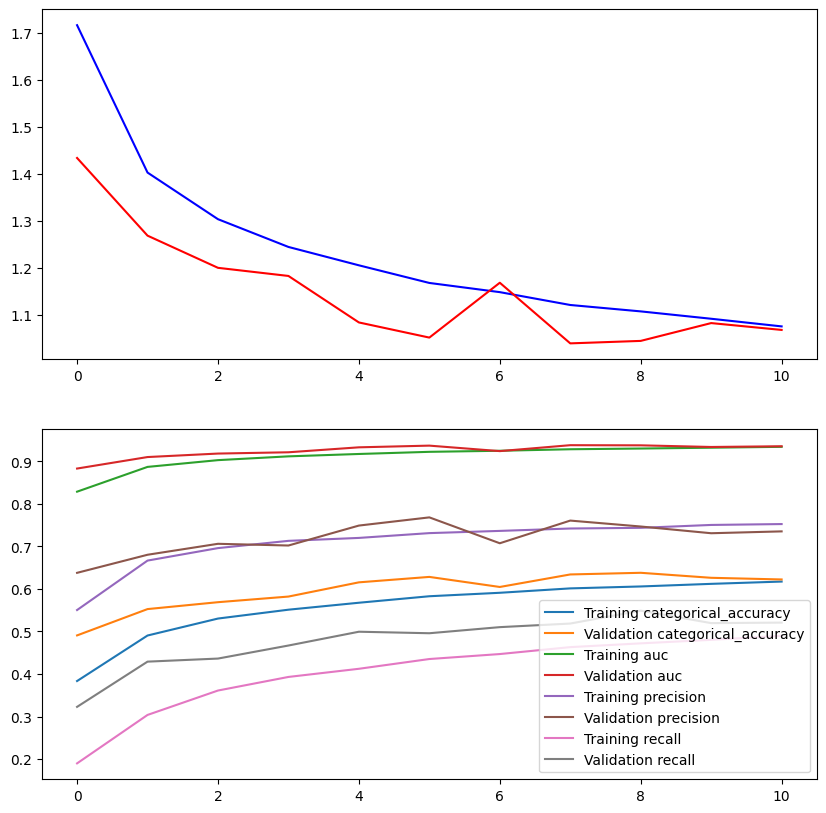

In [49]:
metrics2 = ['categorical_accuracy','auc','precision','recall']
show_training_validation_loss_and_metrics(model1,metrics2)

In [35]:
model1.evaluate(test_it)

1125/1125 [==============================] - 7s 7ms/step - loss: 1.1140 - accuracy: 0.6124 - auc: 0.9302 - precision: 0.7202 - recall: 0.5161 - f1_score: 0.6028


[1.1139541864395142,
 0.6124444603919983,
 0.9302479028701782,
 0.7201891541481018,
 0.5160555839538574,
 array([0.7436447 , 0.6741505 , 0.55020547, 0.4631685 , 0.45864663,
        0.37438044, 0.619894  , 0.7215372 , 0.73009306, 0.692252  ],
       dtype=float32)]

# Architektura drugiego modelu

In [7]:
model2 = Sequential()
model2.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(32, 32, 3)))
model2.add(LayerNormalization())
model2.add(AveragePooling2D((2, 2), strides=2, padding="same"))
model2.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model2.add(LayerNormalization())
model2.add(AveragePooling2D((2, 2), strides=2, padding="same"))
model2.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model2.add(LayerNormalization())
model2.add(AveragePooling2D((2, 2), strides=2, padding="same"))
model2.add(LayerNormalization())
model2.add(Flatten())
model2.add(Dense(units=512))
model2.add(Dense(units=num_classes, activation="softmax"))

In [8]:
model2.compile( 
    loss=loss_func,
    metrics=['categorical_accuracy']
)

In [9]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization (LayerN  (None, 32, 32, 75)       150       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 75)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_1 (Laye  (None, 16, 16, 50)       100       
 rNormalization)                                                 
                                                        

In [10]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model2.fit(
    train_ds,
    validation_data=validation_ds, 
    epochs=20, 
    callbacks = [callback]
)

Epoch 1/20
3938/3938 [==============================] - 47s 10ms/step - loss: 1.7992 - categorical_accuracy: 0.3463 - val_loss: 1.5394 - val_categorical_accuracy: 0.4423
Epoch 2/20
3938/3938 [==============================] - 38s 10ms/step - loss: 1.4444 - categorical_accuracy: 0.4724 - val_loss: 1.5152 - val_categorical_accuracy: 0.4581
Epoch 3/20
3938/3938 [==============================] - 41s 10ms/step - loss: 1.3288 - categorical_accuracy: 0.5187 - val_loss: 1.3450 - val_categorical_accuracy: 0.5187
Epoch 4/20
3938/3938 [==============================] - 42s 11ms/step - loss: 1.2594 - categorical_accuracy: 0.5459 - val_loss: 1.3587 - val_categorical_accuracy: 0.5096
Epoch 5/20
3938/3938 [==============================] - 37s 9ms/step - loss: 1.2098 - categorical_accuracy: 0.5627 - val_loss: 1.2909 - val_categorical_accuracy: 0.5496
Epoch 6/20
3938/3938 [==============================] - 41s 11ms/step - loss: 1.1697 - categorical_accuracy: 0.5790 - val_loss: 1.2398 - val_categorica

In [11]:
model2.evaluate(test_ds)

1125/1125 [==============================] - 6s 5ms/step - loss: 1.1931 - categorical_accuracy: 0.5799


[1.1931078433990479, 0.5799444317817688]

# Architektura trzeciego modelu

In [20]:
model3 = Sequential()
model3.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="sigmoid", 
                 input_shape=(32, 32, 3)))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="sigmoid"))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid"))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="sigmoid"))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Conv2D(16, (3, 3), strides=1, padding="same", activation="sigmoid"))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Flatten())
model3.add(Dense(units=1024))
model3.add(Dropout(0.3))
model3.add(Dense(units=num_classes, activation="softmax"))

model3.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=['accuracy']
)

#model3.summary()

In [21]:
model3.fit(
    train_ds,
    validation_data=validation_ds, 
    epochs=20, 
    verbose=1
)

Epoch 1/20
4500/4500 [==============================] - 413s 91ms/step - loss: 1.7322 - accuracy: 0.3450 - val_loss: 1.5224 - val_accuracy: 0.4284
Epoch 2/20
4500/4500 [==============================] - 419s 93ms/step - loss: 1.4782 - accuracy: 0.4462 - val_loss: 1.3959 - val_accuracy: 0.4806
Epoch 3/20
4500/4500 [==============================] - 415s 92ms/step - loss: 1.3657 - accuracy: 0.4951 - val_loss: 1.3264 - val_accuracy: 0.5087
Epoch 4/20
4500/4500 [==============================] - 418s 93ms/step - loss: 1.3053 - accuracy: 0.5198 - val_loss: 1.2800 - val_accuracy: 0.5286
Epoch 5/20
4500/4500 [==============================] - 417s 93ms/step - loss: 1.2510 - accuracy: 0.5416 - val_loss: 1.2381 - val_accuracy: 0.5519
Epoch 6/20
4500/4500 [==============================] - 413s 92ms/step - loss: 1.2127 - accuracy: 0.5559 - val_loss: 1.2377 - val_accuracy: 0.5539
Epoch 7/20
4500/4500 [==============================] - 422s 94ms/step - loss: 1.1751 - accuracy: 0.5715 - val_loss: 1